<a href="https://colab.research.google.com/github/marcondesc/mcws_wasa/blob/main/Coocorr%C3%AAncia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise bibliográfica


### Carregar os dados e importar as bibliotecas

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

# Baixar stopwords se ainda não estiverem disponíveis
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Definir as stop words
#stop_words = set(stopwords.words('portuguese'))
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Carregar arquivo csv
df = pd.read_csv('/content/scopus_1_418_docs.csv')

### Artigos publicados por ano

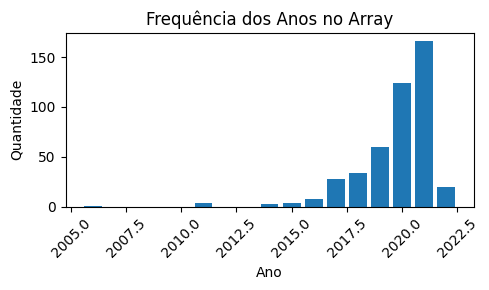

In [3]:
years = df['Year'].astype(int)

# Contar a quantidade de vezes que cada ano aparece
year_counts = Counter(years)

# Separar os dados para o gráfico
anos = list(year_counts.keys())
quantidades = list(year_counts.values())

# Criar o gráfico de barras
plt.figure(figsize=(5, 3))  # Define o tamanho da figura
plt.bar(anos, quantidades)   # Plota as barras

# Adicionar títulos e rótulos
plt.title('Frequência dos Anos no Array')  # Título do gráfico
plt.xlabel('Ano')                          # Rótulo do eixo x
plt.ylabel('Quantidade')                   # Rótulo do eixo y

# Rotacionar os rótulos do eixo x para melhor visualização
plt.xticks(rotation=45)

# Ajustar o layout para que os rótulos não fiquem cortados
plt.tight_layout()

# Exibir o gráfico
plt.show()

### Processamento do texto

In [4]:
def preprocess_text(text, stop_words):
    # Converter para minúsculas
    text = text.lower()
    # Remover pontuação
    text = re.sub(r'[^\w\s]', '', text)
    # Remover stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)
    # tokenização
    tokens = nltk.word_tokenize(text)
    # lematização
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return lemmatized_tokens

In [5]:
# Função para gerar uma matriz de coocorrência a partir de um DataFrame com tokens
def generate_cooccurrence_matrix_from_dataframe(df, text_column):
    texts = [" ".join(tokens) for tokens in df[text_column]]
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(texts)
    cooc_matrix = (X.T * X)
    cooc_matrix.setdiag(0)
    cooc_matrix_df = pd.DataFrame(cooc_matrix.toarray(), index=vectorizer.get_feature_names_out(), columns=vectorizer.get_feature_names_out())
    return cooc_matrix_df

In [6]:
df['Title'] = df['Title'].apply(lambda x: preprocess_text(x, stop_words))

### Grafo de Coocorrência de Termos

In [7]:
def plot_cooccurrence_graph(cooc_matrix_df, threshold=1, k_value=1.5):
    # Cria o grafo
    G = nx.Graph()

    # Adiciona arestas ao grafo com base na matriz de coocorrência e no limiar (threshold)
    for i in range(len(cooc_matrix_df)):
        for j in range(i + 1, len(cooc_matrix_df)):
            if cooc_matrix_df.iat[i, j] >= threshold:  # Adiciona se a coocorrência for maior ou igual ao limiar
                G.add_edge(cooc_matrix_df.index[i], cooc_matrix_df.columns[j], weight=cooc_matrix_df.iat[i, j])

    # Desenhar o grafo com o layout de primavera (spring layout) e k ajustado
    pos = nx.spring_layout(G, seed=42, k=k_value)
    plt.figure(figsize=(16, 12))

    # Desenhar os nós e as arestas
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color="lightblue")
    nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight'] * 0.3 for u, v in G.edges()], alpha=0.3)
    nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

    # Exibir o peso das arestas (frequência de coocorrência)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title("Grafo de Coocorrência de Termos")
    plt.show()

In [8]:
# Gerar a matriz de coocorrência a partir do DataFrame
cooc_matrix_df = generate_cooccurrence_matrix_from_dataframe(df, 'Title')

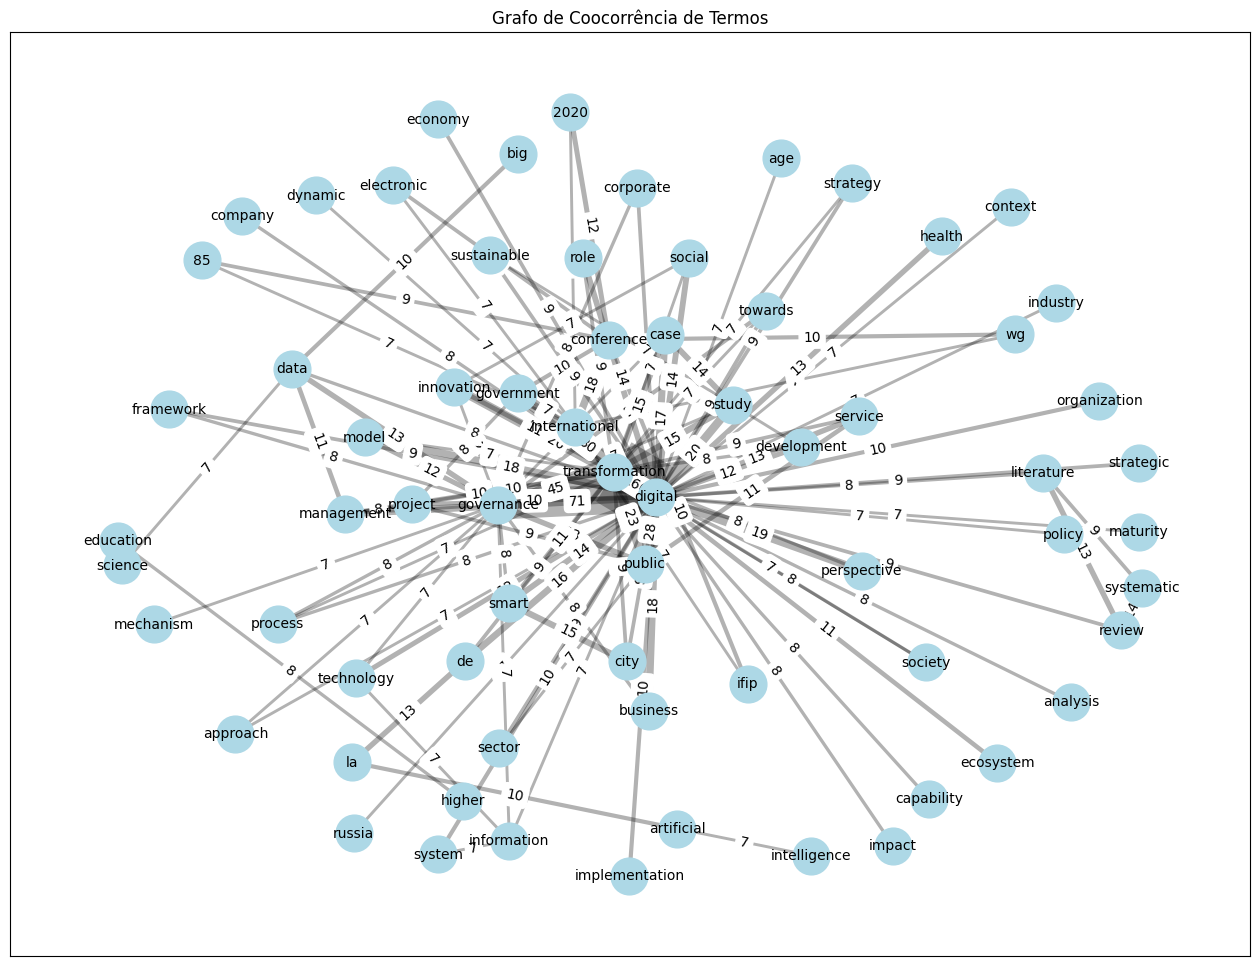

In [9]:
# Plotar a matriz de coocorrência como um grafo
plot_cooccurrence_graph(cooc_matrix_df, threshold=7, k_value=1.8)

### Nuvem de Palavras

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [11]:
def generate_word_cloud_from_dataframe(df, text_column, stop_words=None):
    # Unir todas as listas de tokens em uma string única
    combined_text = " ".join([" ".join(tokens) for tokens in df[text_column]])

    # Gerar a nuvem de palavras
    wordcloud = WordCloud(stopwords=stop_words, background_color='white', width=800, height=400).generate(combined_text)

    # Exibir a nuvem de palavras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

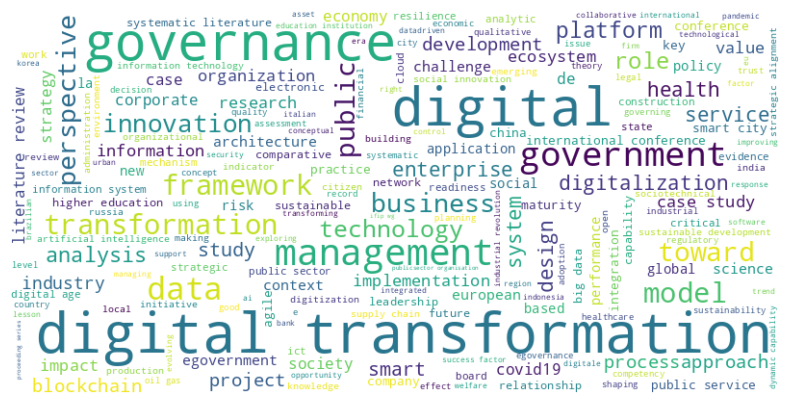

In [12]:
generate_word_cloud_from_dataframe(df, 'Title')

### Gráfico dos termos mais frequentes

In [13]:
# Função para contar os termos e plotar os 20 mais frequentes
def plot_top_20_terms(df, text_column):
    # Unir todas as listas de tokens em uma única lista de palavras
    all_tokens = [token for tokens_list in df[text_column] for token in tokens_list]

    # Contar a frequência de cada termo
    term_counts = Counter(all_tokens)

    # Selecionar os 20 termos mais comuns
    most_common_terms = term_counts.most_common(20)

    # Separar os termos e as contagens para o gráfico
    terms, counts = zip(*most_common_terms)

    # Plotar o gráfico de barras
    plt.figure(figsize=(12, 6))
    plt.bar(terms, counts, color='skyblue')
    plt.title("Top 20 Termos Mais Recorrentes")
    plt.xlabel("Termos")
    plt.ylabel("Frequência")
    plt.xticks(rotation=45)
    plt.show()

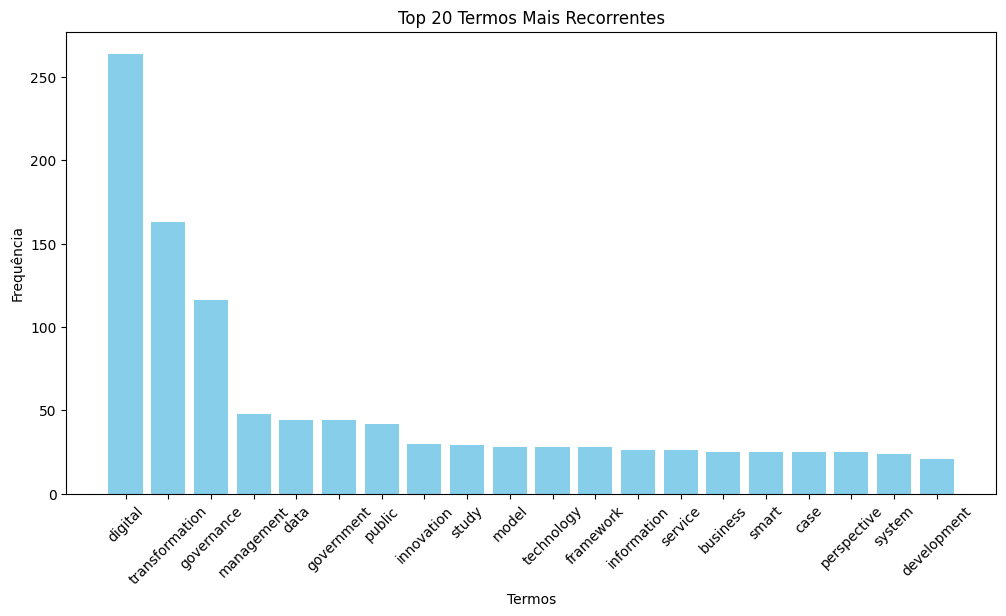

In [14]:
# Gerar o gráfico de barras para os 20 termos mais recorrentes na coluna 'Title'
plot_top_20_terms(df, 'Title')

### Mapa de Calor
Ainda não deu muito certo

In [53]:
import seaborn as sns
# Função para plotar o mapa de calor de coocorrência
def plot_cooccurrence_heatmap(cooc_matrix_df):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cooc_matrix_df, annot=True, cmap="YlGnBu", fmt="d", linewidths=0.5, cbar=True)
    plt.title("Mapa de Calor das Coocorrências de Termos")
    plt.xlabel("Termos")
    plt.ylabel("Termos")
    plt.show()

In [ ]:
# Plotar o mapa de calor da matriz de coocorrência
plot_cooccurrence_heatmap(cooc_matrix_df)

### Dendograma

melhorar a entrada do texto: precisa adaptar de Dataframe para texto, ou fazer a função aceitar a coluna do Dataframe

In [15]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns

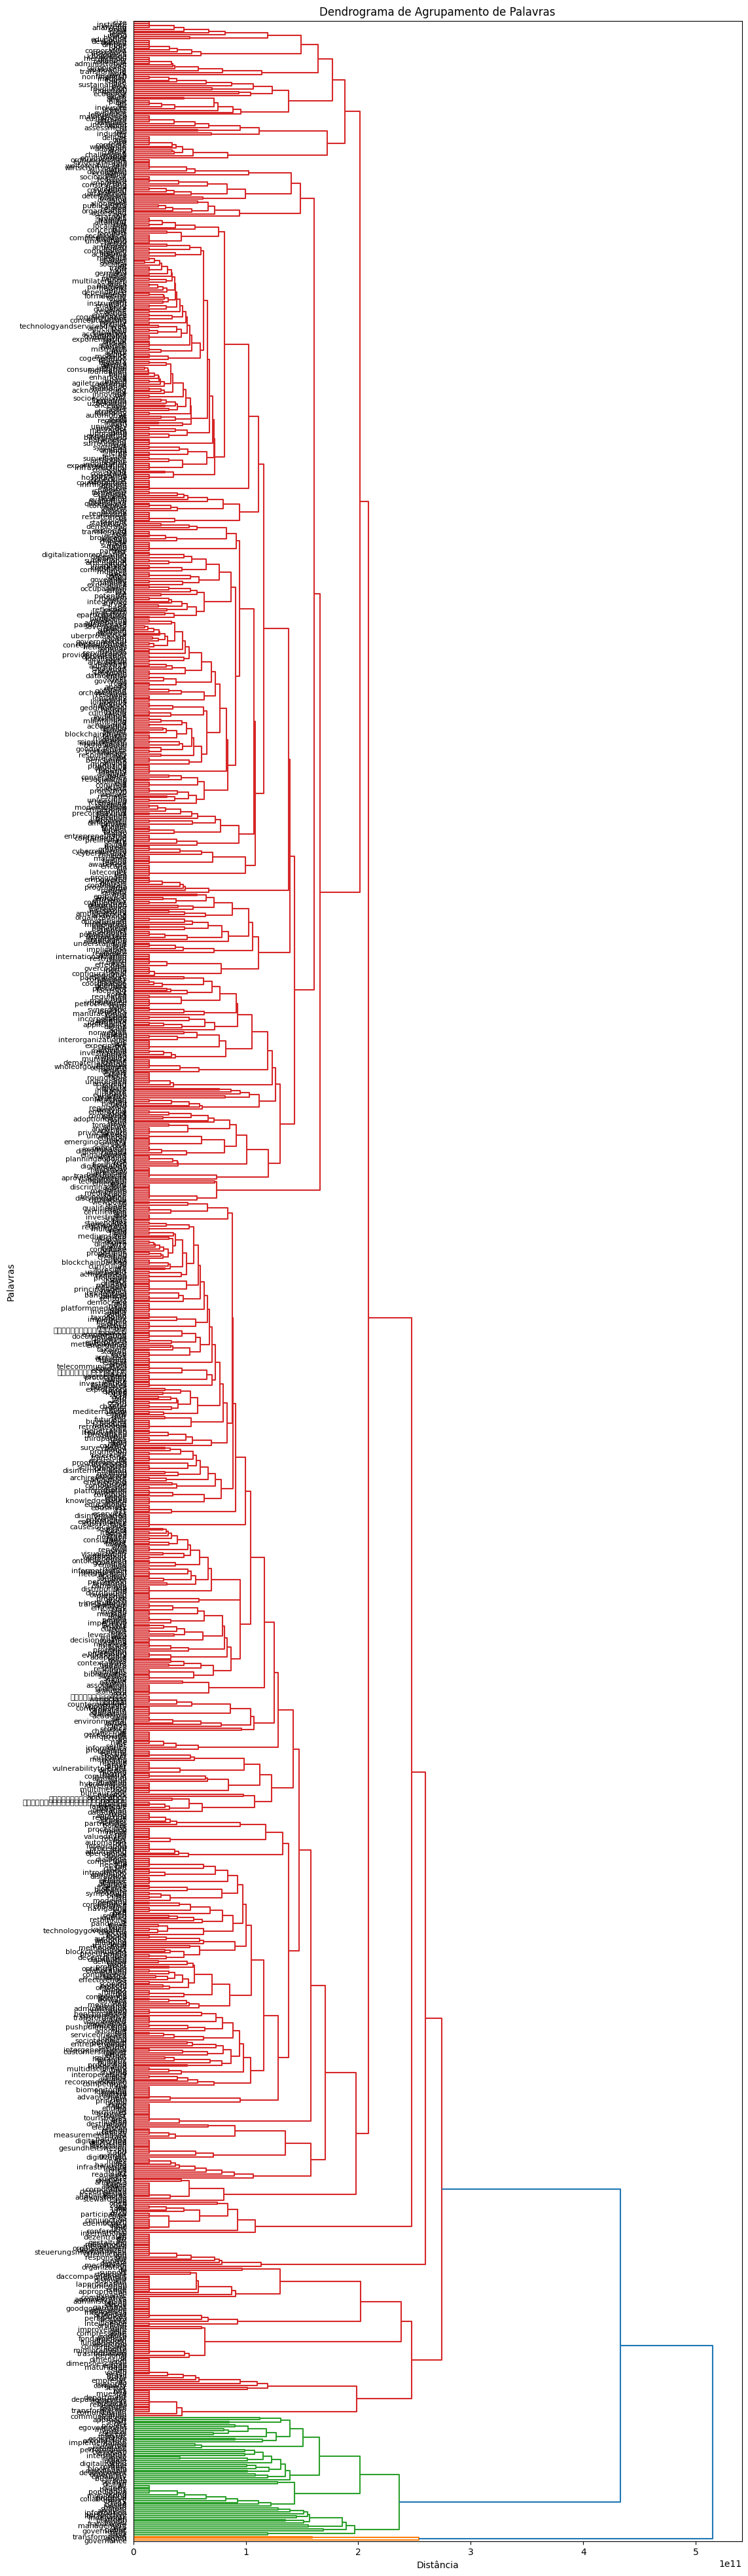

In [18]:
# Função para plotar o dendrograma de palavras
def plot_word_dendrogram(cooc_matrix_df):
    # Converter a matriz de coocorrência em uma matriz de distância (inverso da coocorrência)
    distance_matrix = 1 / (cooc_matrix_df + 1e-10)  # Pequeno valor para evitar divisão por zero

    # Executar o agrupamento hierárquico
    linkage_matrix = linkage(distance_matrix, method='ward')

    # Plotar o dendrograma
    plt.figure(figsize=(12, 50))
    dendrogram(linkage_matrix, labels=cooc_matrix_df.index, orientation='right', leaf_font_size=8)
    plt.title("Dendrograma de Agrupamento de Palavras")
    plt.xlabel("Distância")
    plt.ylabel("Palavras")
    plt.show()

# Plotar o dendrograma de palavras
plot_word_dendrogram(cooc_matrix_df)
